In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import glob

2024-01-29 20:55:29.038946: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 20:55:29.039031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 20:55:29.096568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 20:55:29.217022: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices('GPU')

2024-01-29 20:55:32.648399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 20:55:32.715134: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-29 20:55:32.715183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
csv_files = glob.glob('./driving_data/*.csv')
dfs = []
for file in csv_files:
    dfs.append(pd.read_csv(file))
df = pd.concat(dfs)
df

,pitch,roll,acceleration_x,acceleration_y,acceleration_z,angular_velocity_x,angular_velocity_y,angular_velocity_z,distance,time,jerk_x,jerk_y,jerk_z,is_running_backoff
0,-1.0,0.0,205.85300,136.43750,9787.594,-0.055989,-0.095555,0.005286,2000.0,2024-01-12 16:26:33.393240,0.000000,0.000000,0.000000,False
1,-3.0,2.0,636.70830,330.32230,9162.854,2.254011,-2.895555,-0.414714,2000.0,2024-01-12 16:26:33.513343,3587.381664,1614.321041,-5201.701873,False
2,-1.0,-1.0,550.53720,-526.60080,9876.159,2.114011,-2.755555,-2.724714,2000.0,2024-01-12 16:26:33.693540,-478.204965,-4755.479281,3958.473227,False
3,-4.0,0.0,679.79380,2.39364,9201.152,-0.545989,-0.095555,3.645286,1843.0,2024-01-12 16:26:33.933171,539.398492,2207.537589,-2816.860089,False
4,0.0,2.0,-86.17104,440.42980,10618.190,0.294011,-0.025555,-3.984714,1803.0,2024-01-12 16:26:34.113693,-4243.055362,2426.497380,7849.669292,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.0,-3.0,40.69188,-497.87710,8748.754,-5.146463,12.652540,177.248700,2000.0,2024-01-12 16:24:31.735440,-29213.812318,279.877173,-28414.193606,True
275,0.0,-3.0,40.69188,-497.87710,8748.754,-5.146463,12.652540,177.248700,2000.0,2024-01-12 16:24:31.735440,-29213.812318,279.877173,-28414.193606,False
276,-3.0,-3.0,643.88920,-646.28280,9414.187,-1.086463,2.572544,171.018800,2000.0,2024-01-12 16:24:31.976498,2502.291233,-615.643123,2760.468435,False
277,0.0,0.0,9.57456,-21.54276,9500.357,2.483537,-7.297456,6.378747,2000.0,2024-01-12 16:24:32.156019,-3533.372920,3480.038770,479.999554,False


In [4]:
# We only want to keep the rows where nothing is happening or when it starts the backoff procedure. 
# The data during the backoff procedure is not useful.
backoff_start = (df['is_running_backoff'] & -df['is_running_backoff'].shift(fill_value=False))
filter_mask = -df['is_running_backoff'] | backoff_start
filtered_df = df[filter_mask]
filtered_df

,pitch,roll,acceleration_x,acceleration_y,acceleration_z,angular_velocity_x,angular_velocity_y,angular_velocity_z,distance,time,jerk_x,jerk_y,jerk_z,is_running_backoff
0,-1.0,0.0,205.85300,136.43750,9787.594,-0.055989,-0.095555,0.005286,2000.0,2024-01-12 16:26:33.393240,0.000000,0.000000,0.000000,False
1,-3.0,2.0,636.70830,330.32230,9162.854,2.254011,-2.895555,-0.414714,2000.0,2024-01-12 16:26:33.513343,3587.381664,1614.321041,-5201.701873,False
2,-1.0,-1.0,550.53720,-526.60080,9876.159,2.114011,-2.755555,-2.724714,2000.0,2024-01-12 16:26:33.693540,-478.204965,-4755.479281,3958.473227,False
3,-4.0,0.0,679.79380,2.39364,9201.152,-0.545989,-0.095555,3.645286,1843.0,2024-01-12 16:26:33.933171,539.398492,2207.537589,-2816.860089,False
4,0.0,2.0,-86.17104,440.42980,10618.190,0.294011,-0.025555,-3.984714,1803.0,2024-01-12 16:26:34.113693,-4243.055362,2426.497380,7849.669292,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,19.0,-24.0,-2549.22700,-3023.16700,6582.510,-8.926463,-20.247460,-91.831250,2000.0,2024-01-12 16:24:30.655430,-17175.118334,-19083.460541,-14225.857888,True
275,0.0,-3.0,40.69188,-497.87710,8748.754,-5.146463,12.652540,177.248700,2000.0,2024-01-12 16:24:31.735440,-29213.812318,279.877173,-28414.193606,False
276,-3.0,-3.0,643.88920,-646.28280,9414.187,-1.086463,2.572544,171.018800,2000.0,2024-01-12 16:24:31.976498,2502.291233,-615.643123,2760.468435,False
277,0.0,0.0,9.57456,-21.54276,9500.357,2.483537,-7.297456,6.378747,2000.0,2024-01-12 16:24:32.156019,-3533.372920,3480.038770,479.999554,False


In [51]:
from sklearn.preprocessing import MinMaxScaler
for col in ['pitch', 'roll', 'acceleration_x', 'acceleration_y', 'acceleration_z', 
            'angular_velocity_x', 'angular_velocity_y', 'angular_velocity_z', 'distance', 'jerk_x', 'jerk_y', 'jerk_z']:
    scaler = MinMaxScaler()
    filtered_df[col] = scaler.fit_transform(filtered_df[[col]])
filtered_df

/tmp/ipykernel_12/62404578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = scaler.fit_transform(filtered_df[[col]])
/tmp/ipykernel_12/62404578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[col] = scaler.fit_transform(filtered_df[[col]])
/tmp/ipykernel_12/62404578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,pitch,roll,acceleration_x,acceleration_y,acceleration_z,angular_velocity_x,angular_velocity_y,angular_velocity_z,distance,time,jerk_x,jerk_y,jerk_z,is_running_backoff
0,0.431373,0.836735,0.672459,0.639962,0.719123,0.857990,0.513387,0.495950,1.000000,2024-01-12 16:26:33.393240,0.687615,0.728314,0.664863,False
1,0.411765,0.846939,0.682714,0.647743,0.701234,0.875006,0.490464,0.494943,1.000000,2024-01-12 16:26:33.513343,0.702060,0.735152,0.639645,False
2,0.431373,0.831633,0.680663,0.613352,0.721659,0.873975,0.491610,0.489404,1.000000,2024-01-12 16:26:33.693540,0.685689,0.708170,0.684054,False
3,0.401961,0.836735,0.683740,0.634582,0.702330,0.854381,0.513387,0.504678,0.919898,2024-01-12 16:26:33.933171,0.689787,0.737665,0.651207,False
4,0.441176,0.846939,0.665508,0.652161,0.742906,0.860568,0.513960,0.486383,0.899490,2024-01-12 16:26:34.113693,0.670529,0.738593,0.702919,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,0.627451,0.714286,0.606882,0.513160,0.627348,0.792651,0.348406,0.275750,1.000000,2024-01-12 16:24:30.655430,0.618454,0.647477,0.595894,True
275,0.441176,0.821429,0.668528,0.614505,0.689376,0.820494,0.617754,0.920933,1.000000,2024-01-12 16:24:31.735440,0.569977,0.729500,0.527108,False
276,0.411765,0.821429,0.682885,0.608549,0.708430,0.850400,0.535230,0.905995,1.000000,2024-01-12 16:24:31.976498,0.697691,0.725706,0.678246,False
277,0.441176,0.836735,0.667787,0.633621,0.710898,0.876697,0.454426,0.511232,1.000000,2024-01-12 16:24:32.156019,0.673387,0.743056,0.667190,False


In [52]:
# Convert to tensors. Every tensor contains 10 entries. 
history_size = 10
tensors = []
# TODO: normalize all columns to be between 0 and 1
for start in range(len(filtered_df) - history_size):
    window_df = filtered_df.iloc[start:start+history_size].drop(columns=["time","is_running_backoff"]).astype('float32')
    tensors.append(tf.convert_to_tensor(window_df))
    
# The label is whether the backoff procedure is started (1 when the last line of the tensor had the backoff procedure started)
labels = filtered_df['is_running_backoff'].iloc[history_size:].astype('int64').values


In [53]:
# Data set is not very balanced
# Using inspiration from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
neg, pos = np.bincount(labels)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 639
    Positive: 27 (4.23% of total)


In [54]:
print(labels[0])
print(tensors[0][9]) # Because of the history size this should match with the 10th row in the dataframe above

0
tf.Tensor(
[0.42156863 0.8214286  0.6775866  0.611047   0.69540787 0.8188033
 0.5019253  0.4977962  1.         0.6765628  0.70871276 0.6462217 ], shape=(12,), dtype=float32)


In [55]:
print(labels[10])
print(tensors[10][9]) # The 20th row above. The first one that has a positive label

1
tf.Tensor(
[0.4117647  0.86734694 0.6819166  0.67569643 0.7039754  0.8631466
 0.5036445  0.496957   0.01581633 0.69789344 0.75529    0.64397955], shape=(12,), dtype=float32)


In [56]:
from sklearn.model_selection import train_test_split
train_tensors, test_tensors, train_labels, test_labels = train_test_split(tensors, labels, test_size=0.2)
train_tensors, val_tensors, train_labels, val_labels = train_test_split(train_tensors, train_labels, test_size=0.2)

In [57]:
len(train_tensors), len(val_tensors), len(test_tensors)

(408, 103, 128)

In [58]:
# This is clearly not very well balanced because of the small amount of data I currently have
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0417
Average class probability in validation set: 0.0485
Average class probability in test set:       0.0391


In [86]:
from tensorflow import keras
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [88]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(history_size, 12)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [89]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 120)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               15488     
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15617 (61.00 KB)
Trainable params: 15617 (61.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [91]:
# TODO: set initial bias
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

In [92]:
history = model.fit(
    np.array(train_tensors), 
    train_labels,
    epochs=EPOCHS,
    batch_size=1,
    validation_data=(np.array(val_tensors), val_labels),
    callbacks=[early_stopping])

Epoch 1/100
408/408 [==============================] - 5s 8ms/step - loss: 0.2041 - cross entropy: 0.2041 - Brier score: 0.0441 - tp: 0.0000e+00 - fp: 1.0000 - tn: 390.0000 - fn: 17.0000 - accuracy: 0.9559 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4203 - prc: 0.0351 - val_loss: 0.2078 - val_cross entropy: 0.2078 - val_Brier score: 0.0469 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 98.0000 - val_fn: 5.0000 - val_accuracy: 0.9515 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7082 - val_prc: 0.0912
Epoch 2/100
408/408 [==============================] - 3s 6ms/step - loss: 0.1827 - cross entropy: 0.1827 - Brier score: 0.0409 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 391.0000 - fn: 17.0000 - accuracy: 0.9583 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5139 - prc: 0.0429 - val_loss: 0.1849 - val_cross entropy: 0.1849 - val_Brier score: 0.0454 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 98.0000 - val_fn: 5.0000 - val_accuracy: 0.9515 - v

In [93]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


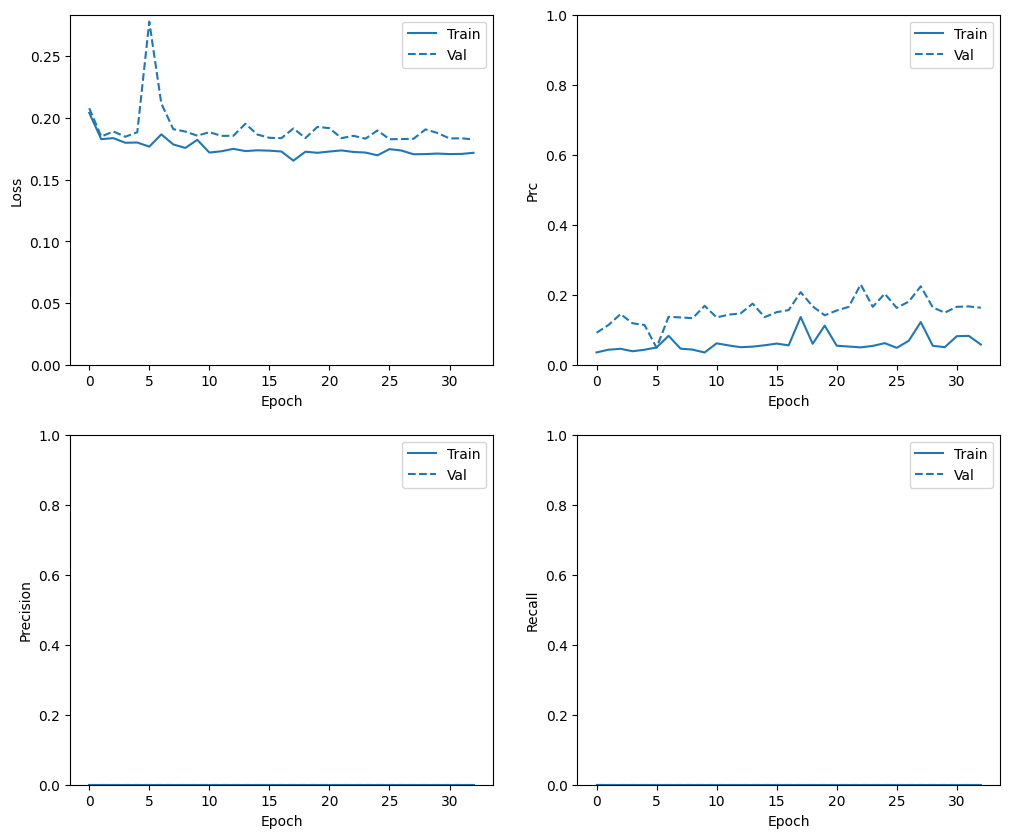

In [94]:
plot_metrics(history)